<a href="https://colab.research.google.com/github/MarcinAn/analiza_danych/blob/main/analiza_danych.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pobieranie danych**

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df= pd.read_csv('HRDataset.csv')
df['Employee_Name'].fillna(0, inplace= True)
df= df[df['Employee_Name'] != 0]

# **Czy istnieje zależność pomiędzy tym, kto jest bezpośrednim przełożonym (ManagerName, ManagerID) danego pracownika, a oceną wydajności pracy (PerformanceScore)?**

In [54]:
manager_performance= df[['ManagerName','PerformanceScore']]
manager_performance.dropna(inplace= True)
manager_performance['PerformanceCount']= manager_performance['PerformanceScore']
manager_performance_pivot=manager_performance.pivot_table(values= 'PerformanceCount', index= 'ManagerName', columns= 'PerformanceScore', aggfunc= 'count').fillna(0)

sum_rows= manager_performance_pivot[['Exceeds', 'Fully Meets', 'Needs Improvement', 'PIP']].sum(axis=1)
manager_performance_pivot['Exceeds_percent']= manager_performance_pivot['Exceeds'] / sum_rows
manager_performance_pivot['Fully_meets_percent']= manager_performance_pivot['Fully Meets'] / sum_rows
manager_performance_pivot['Needs_improvement_percent']= manager_performance_pivot['Needs Improvement'] / sum_rows
manager_performance_pivot['PIP_percent']= manager_performance_pivot['PIP'] / sum_rows
manager_performance_pivot.drop(['Exceeds', 'Fully Meets', 'Needs Improvement', 'PIP'], axis= 1, inplace= True)

<ipython-input-54-97329981ca1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manager_performance.dropna(inplace= True)
<ipython-input-54-97329981ca1b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manager_performance['PerformanceCount']= manager_performance['PerformanceScore']


<Figure size 640x480 with 0 Axes>

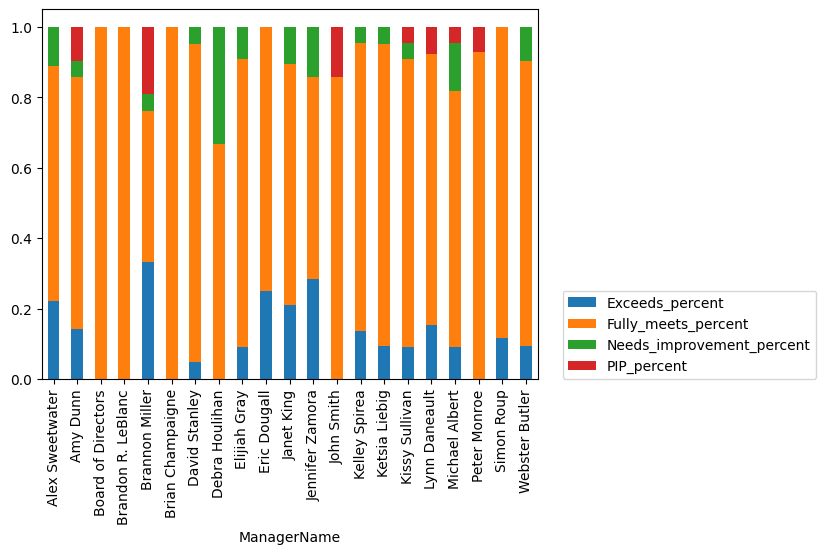

In [55]:
from numpy.ma.core import size
plt.figure()
ax= manager_performance_pivot.plot(kind= 'bar', stacked= True)
ax.legend(loc= (1.05,0.0))
plt.show()

***Analiza wyników pokazuje, że managerowie określją pracowników pozytywnie, jako fully meets oraz exceeds. Ocena Needs improvement oraz PIP dotyczy widocznie mniejszej ilości pracowników***

---



# **Jakie źródła pozyskania pracownika (Recruitment Source) są najlepsze, jeśli zależy nam na jak najdłuższym stażu pracowników?**

In [56]:
recruitment_seniority= df[['RecruitmentSource', 'DateofHire', 'DateofTermination', 'Employee_Name']]

In [57]:
recruitment_seniority['DateofTermination']= pd.to_datetime(df['DateofTermination'], format='%m/%d/%y')
recruitment_seniority['DateofHire']= pd.to_datetime(df['DateofHire'], format='%m/%d/%Y')

<ipython-input-57-5579355b54b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruitment_seniority['DateofTermination']= pd.to_datetime(df['DateofTermination'], format='%m/%d/%y')
<ipython-input-57-5579355b54b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruitment_seniority['DateofHire']= pd.to_datetime(df['DateofHire'], format='%m/%d/%Y')


In [58]:
import datetime as dt
def count_seniority(row):
    if pd.isnull(row['DateofTermination']):
        end_date= dt.datetime(2019,9,27)
    else:
        end_date= row['DateofTermination']
    return (end_date- row['DateofHire'])/np.timedelta64(1,'Y')

In [59]:
recruitment_seniority['Seniority'] = recruitment_seniority.apply(lambda row: count_seniority(row),axis=1)

<ipython-input-59-6fa5160e980a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruitment_seniority['Seniority'] = recruitment_seniority.apply(lambda row: count_seniority(row),axis=1)


In [60]:
recruitment_seniority_group= recruitment_seniority.groupby(['RecruitmentSource']).agg({'Seniority':'mean', 'Employee_Name':'count'})
recruitment_seniority_group.reset_index(inplace= True)
recruitment_seniority_group['Seniority']= round(recruitment_seniority_group['Seniority'],2)
recruitment_seniority_group.sort_values(by=['Employee_Name'], ascending= False, inplace= True)

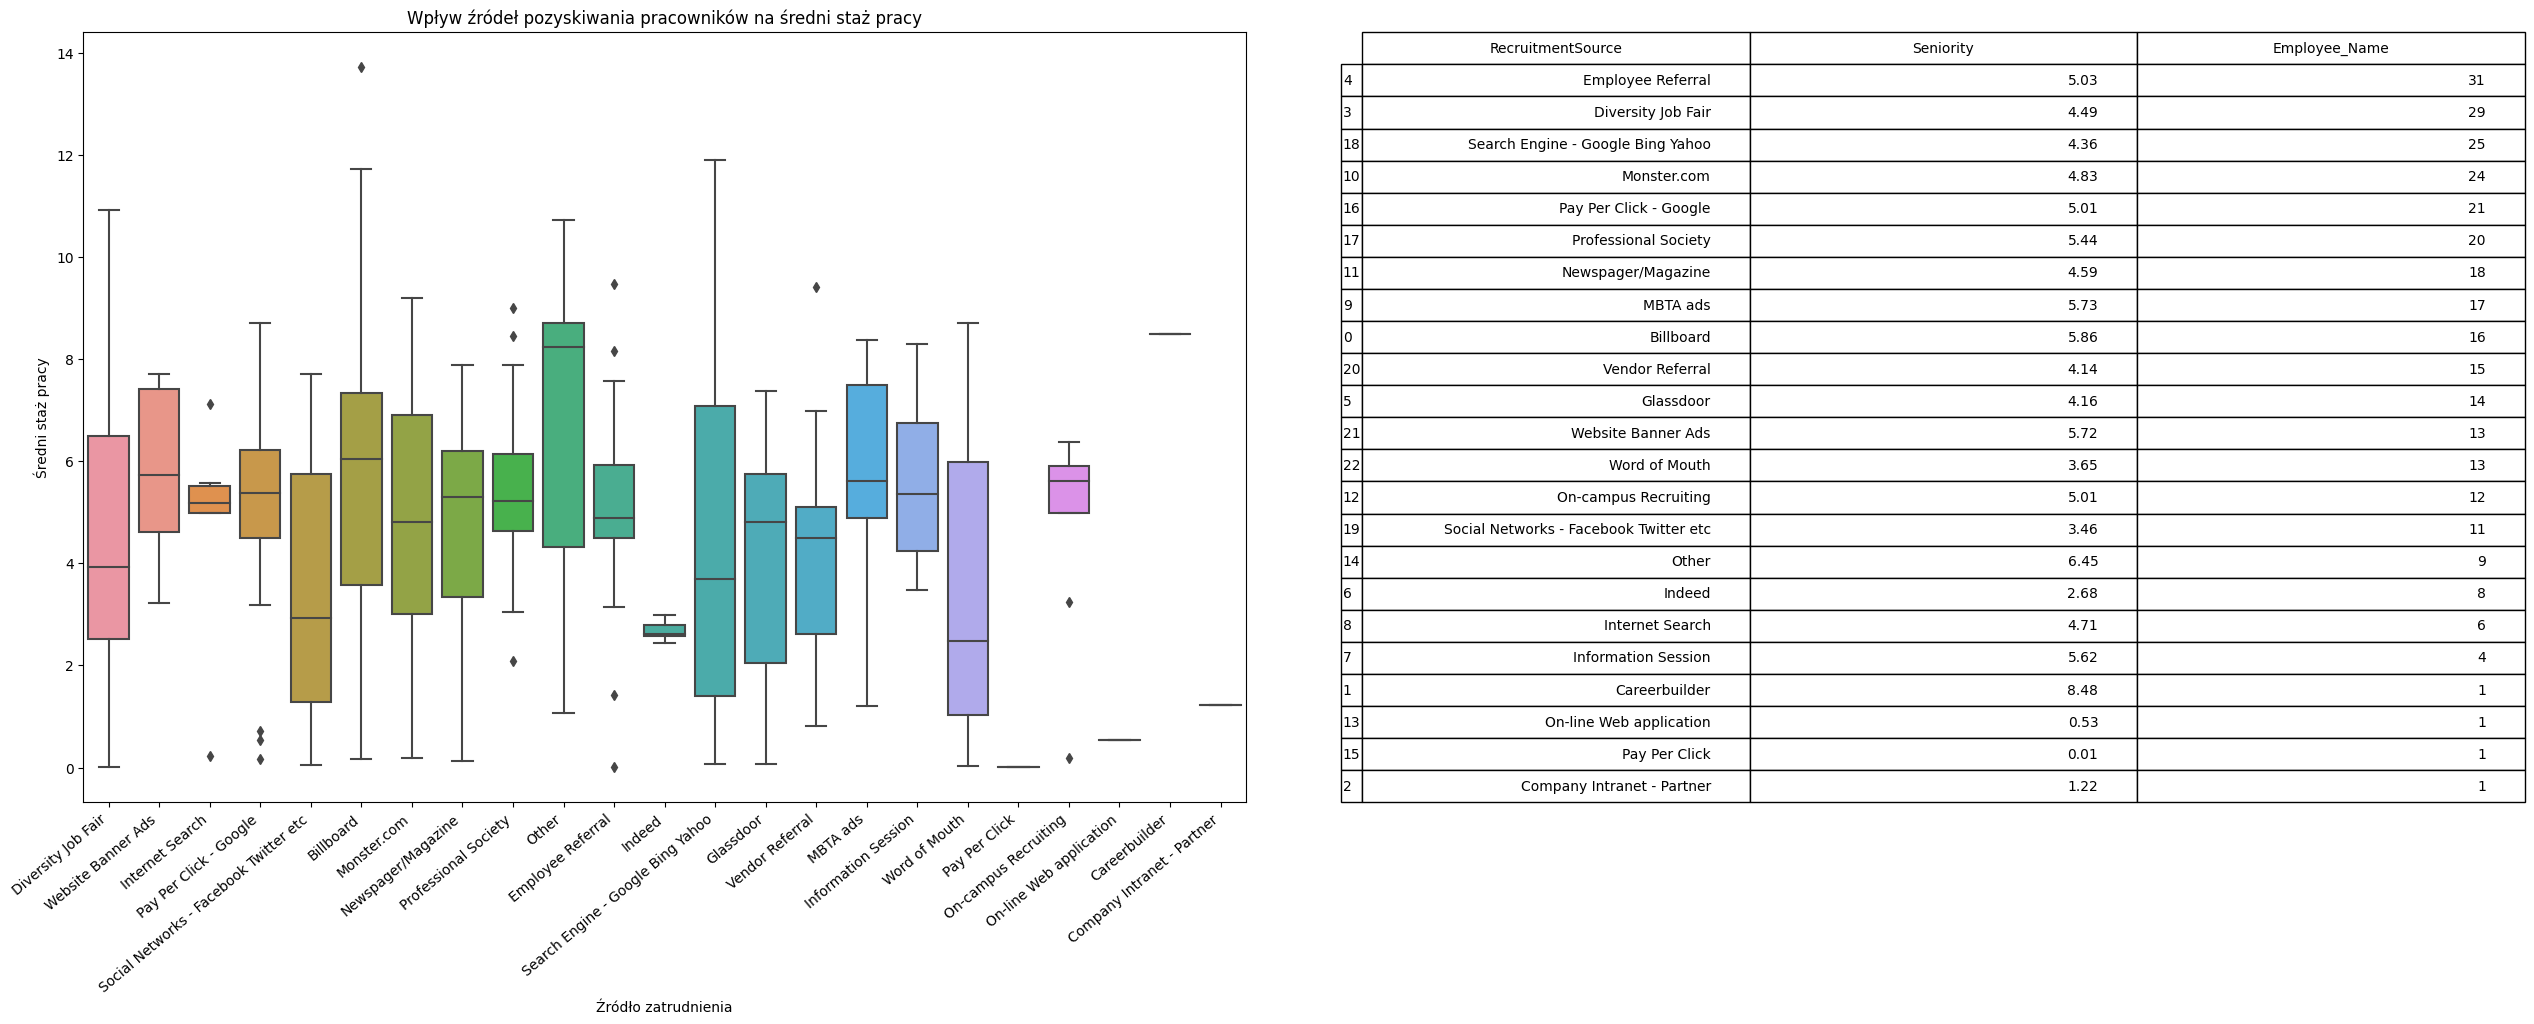

In [61]:
plt.figure(figsize=(15,10))
ax=sns.boxplot(x= 'RecruitmentSource',y= 'Seniority', data=recruitment_seniority)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha= "right")
plt.xlabel('Źródło zatrudnienia')
plt.ylabel('Średni staż pracy')
plt.title('Wpływ źródeł pozyskiwania pracowników na średni staż pracy')
tb = plt.table(cellText=recruitment_seniority_group.values, rowLabels=recruitment_seniority_group.index,
               colLabels=recruitment_seniority_group.columns, bbox=(1.1, 0, 1, 1))
tb.auto_set_font_size(False)
tb.set_fontsize(10)
plt.show()

**Najdłuższy staż zaoserwowano u pracowników pozyskanych za pomocą Billboard ze średnim stażem pracy 6 lat. Ilość pozyskanych z tego źródła pracowników wynosi 16.**

---



# **Czy stan cywilny (MartialDesc) pracownika koreluje w jakikolwiek sposób z zadowoleniem z pracy (EmpSatisfaction)?**

In [62]:
marital_satisfaction= df[['MaritalDesc', 'EmpSatisfaction']]
marital_satisfaction.dropna(inplace= True)
marital_satisfaction
marital_satisfaction_pivot=marital_satisfaction.pivot_table(values= 'EmpSatisfaction', index= 'MaritalDesc', aggfunc= 'mean')
marital_satisfaction_pivot.reset_index(inplace= True)
marital_satisfaction_pivot.sort_values(by= 'EmpSatisfaction', ascending= False, inplace= True)

<ipython-input-62-da1e7edb9530>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marital_satisfaction.dropna(inplace= True)


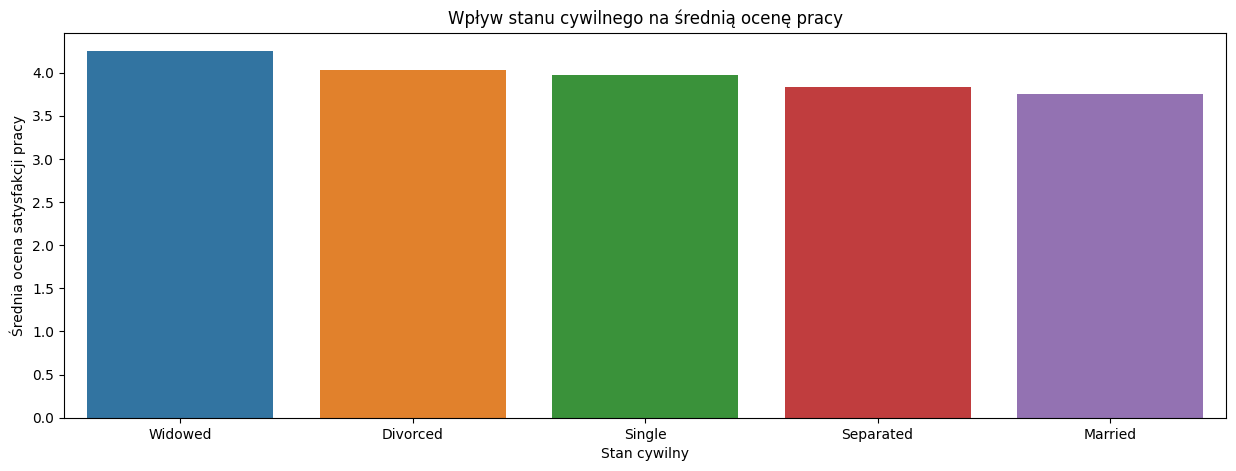

In [63]:
plt.figure(figsize= (15,5))
sns.barplot(x= 'MaritalDesc',y= 'EmpSatisfaction', data= marital_satisfaction_pivot)
plt.xlabel('Stan cywilny')
plt.ylabel('Średnia ocena satysfakcji pracy')
plt.title('Wpływ stanu cywilnego na średnią ocenę pracy')
plt.show()

In [64]:
print(round(marital_satisfaction_pivot.iloc[0,1]-marital_satisfaction_pivot.iloc[4,1],1))

0.5


**Różnica pomiędzy najlepiej oceniającymi swoją pracę "Windowed" a najgorzej oceniającymi "Married" wynosi około 0,5 punkta. Zadowolenie pracy jest w minimalnym stopniu zależne od stanu cywilnego**

---



# **Jak wygląda struktura wieku aktualnie zatrudnionych pracowników?**

In [65]:
age=df[['DOB', 'DateofTermination','SpecialProjectsCount', 'Sex']]
age.fillna(0, inplace= True)
age=age[age['DateofTermination'] == 0]
age.drop('DateofTermination', axis= 1, inplace= True)
age=age[age['DOB'] != 0]

<ipython-input-65-32f2783c2527>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age.fillna(0, inplace= True)


In [66]:
def calculate_age(x):
    if (int(x[-2:]) > 23):
        return 2019 - (1900 + int(x[-2:]))
    else:
        return 2019 - (2000 + int(x[-2:]))
age['age']=age['DOB'].apply(lambda x: calculate_age(x))

def check_if_still_working(x):
    if x == 0:
        return 'Yes'
    else:
        return 'No'

In [67]:
age_violin=df[['Employee_Name', 'DOB', 'DateofTermination','SpecialProjectsCount', 'Sex']]
age_violin['DateofTermination'].fillna(0, inplace= True)
age_violin['StillWorking']= age_violin['DateofTermination'].apply(lambda x: check_if_still_working(x))
age_violin['age']=age_violin['DOB'].apply(lambda x: calculate_age(x))

<ipython-input-67-49e09233bb18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_violin['DateofTermination'].fillna(0, inplace= True)
<ipython-input-67-49e09233bb18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_violin['StillWorking']= age_violin['DateofTermination'].apply(lambda x: check_if_still_working(x))
<ipython-input-67-49e09233bb18>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

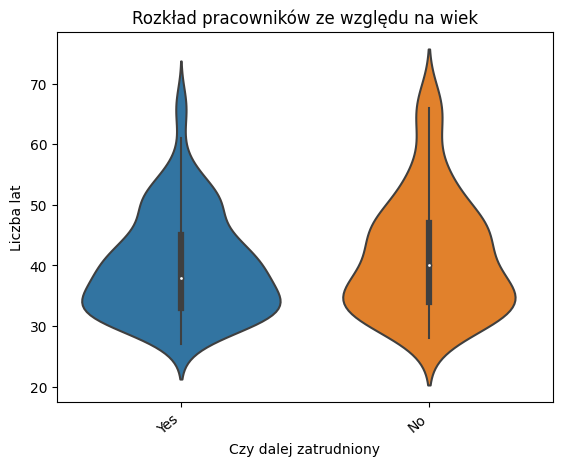

In [68]:
plt.figure()
ax=sns.violinplot(x= 'StillWorking', y= 'age', data= age_violin)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha= "right")
plt.xlabel('Czy dalej zatrudniony')
plt.ylabel('Liczba lat')
plt.title('Rozkład pracowników ze względu na wiek')
plt.show()

Powyższy wykres przedstawia rozkład zatrudnienia aktualnych oraz byłych pracowników z podziałem na ilość przeprwacowanych lat.
Najwięcej zarówno aktualnie pracujących jak i byłych pracowników mieści się w przedziale od 30 do 40 lat.

# **Czy starsi pracownicy pracują nad większą liczbą specjalnych projektów niż młodsi pracownicy?**

In [69]:
special_pivot=age.pivot_table(values= 'SpecialProjectsCount', index= ['age', 'Sex'], aggfunc= 'sum')
special_pivot.reset_index(inplace= True)
special_pivot.sort_values(by= 'age', inplace= True)

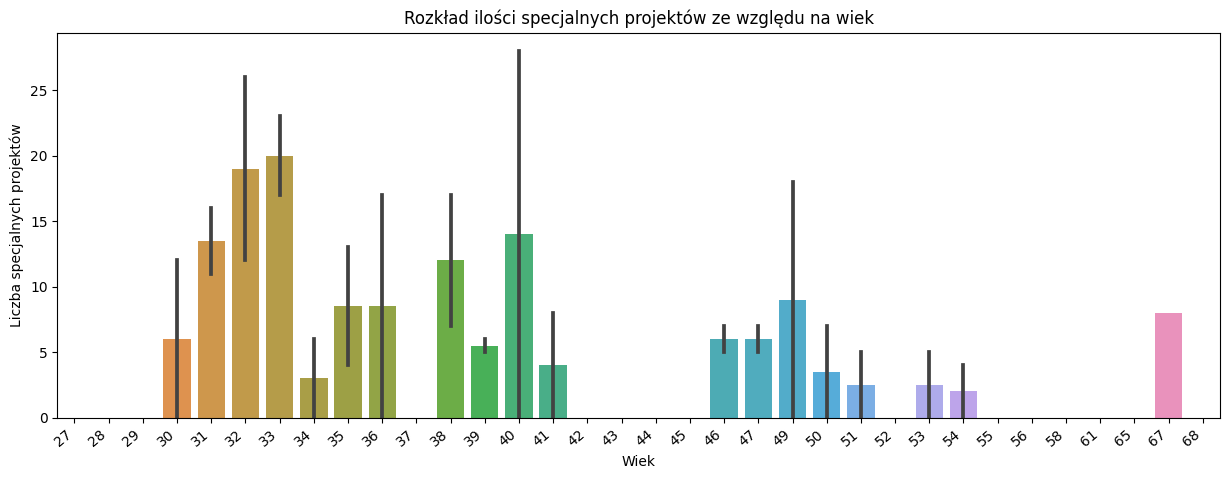

In [70]:
plt.figure(figsize=(15,5))
ax=sns.barplot(x= 'age', y= 'SpecialProjectsCount', data= special_pivot)
ax.set_xticklabels(ax.get_xticklabels(), rotation= 40, ha= "right")
plt.xlabel('Wiek')
plt.ylabel('Liczba specjalnych projektów')
plt.title('Rozkład ilości specjalnych projektów ze względu na wiek')
plt.show()

**Pracownicy w przedziale od 31 do 33 lat pracują nad największą ilością specjalnych projektów.**

---

